In [2]:
# ============================
# 📌 Cell 1: Install Dependencies
# ============================
# ✅ Install dependencies with working Box2D for Google Colab
!apt-get install -y swig  # Needed for Box2D compilation
!pip install gymnasium[box2d] stable-baselines3[extra] opencv-python imageio box2d box2d-kengz --quiet


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
swig is already the newest version (4.0.2-1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [13]:
# ============================
# 📌 Cell 2: Imports
# ============================
import cv2
import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym
from gymnasium.wrappers import ResizeObservation

from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import (
    DummyVecEnv, VecTransposeImage, VecMonitor, VecNormalize
)
from stable_baselines3.common.callbacks import CheckpointCallback

In [14]:
# ============================
# 📌 Cell 3: Environment Wrapper
# ============================
class FloatActionWrapper(gym.ActionWrapper):
    def action(self, act):
        return np.array(act, dtype=np.float64)

def create_environment():
    def _init():
        environment = gym.make("CarRacing-v3", render_mode="rgb_array")
        environment = FloatActionWrapper(environment)
        environment = Monitor(environment)
        return environment
    return _init

In [15]:
# ============================
# 📌 Cell 4: Create Environment
# ============================
vector_env = DummyVecEnv([create_environment()])

Type of initial_obs: <class 'numpy.ndarray'>
Observation shape: (96, 96, 3)


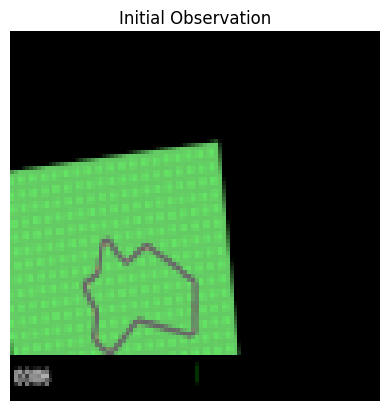

In [16]:
# ============================
# 📌 Cell 5: Reset & Show First Frame
# ============================
initial_obs = vector_env.reset()
print("Type of initial_obs:", type(initial_obs))
print("Observation shape:", initial_obs[0].shape)

plt.imshow(initial_obs[0])  # Already (H, W, C)
plt.title("Initial Observation")
plt.axis('off')
plt.show()

In [17]:
# ============================
# 📌 Cell 6: Create PPO Agent
# ============================
ppo_agent = PPO(
    policy="CnnPolicy",
    env=vector_env,
    verbose=1,
    tensorboard_log="./ppo_carracing_tensorboard/"
)

Using cuda device
Wrapping the env in a VecTransposeImage.


In [18]:
# ============================
# 📌 Cell 7: Checkpoint Callback
# ============================
checkpoint_saver = CheckpointCallback(
    save_freq=10000,
    save_path="./ppo_carracing_checkpoints/",
    name_prefix="ppo_carracing"
)

In [19]:
# ============================
# 📌 Cell 8: Train PPO Agent
# ============================
ppo_agent.learn(
    total_timesteps=200_000,  # Increase later for better results
    callback=checkpoint_saver
)


Logging to ./ppo_carracing_tensorboard/PPO_3
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -50.3    |
| time/              |          |
|    fps             | 89       |
|    iterations      | 1        |
|    time_elapsed    | 22       |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | -47.8        |
| time/                   |              |
|    fps                  | 84           |
|    iterations           | 2            |
|    time_elapsed         | 48           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0066773305 |
|    clip_fraction        | 0.0525       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.26        |
|    explaine

In [20]:
ppo_agent.save("./ppo_carracing_final_model")
print("✅ Trained PPO agent saved at './ppo_carracing_final_model'")

✅ Trained PPO agent saved at './ppo_carracing_final_model'


In [21]:
import os
from stable_baselines3.common.vec_env import VecVideoRecorder

record_dir = "./ppo_carracing_videos/"
record_steps = 1000  # Number of timesteps in the video

# Create directory to store videos
os.makedirs(record_dir, exist_ok=True)

# Re-create environment for video recording
video_env = DummyVecEnv([create_environment()])
video_env = VecTransposeImage(video_env)
video_env = VecVideoRecorder(
    video_env,
    record_dir,
    record_video_trigger=lambda ep: ep == 0,  # Record first episode
    video_length=record_steps,
    name_prefix="ppo_carracing_demo"
)

# Run one episode and record
obs = video_env.reset()
for _ in range(record_steps):
    action, _ = ppo_agent.predict(obs, deterministic=True)
    obs, _, done, _ = video_env.step(action)
    if done:
        obs = video_env.reset()

video_env.close()

print(f"🎥 Video saved to {record_dir}")

Saving video to /content/ppo_carracing_videos/ppo_carracing_demo-step-0-to-step-1000.mp4


/usr/local/lib/python3.11/dist-packages/moviepy/config_defaults.py:1: DeprecationWarning: invalid escape sequence '\P'
  """


Moviepy - Building video /content/ppo_carracing_videos/ppo_carracing_demo-step-0-to-step-1000.mp4.
Moviepy - Writing video /content/ppo_carracing_videos/ppo_carracing_demo-step-0-to-step-1000.mp4



Moviepy - Done !
Moviepy - video ready /content/ppo_carracing_videos/ppo_carracing_demo-step-0-to-step-1000.mp4
🎥 Video saved to ./ppo_carracing_videos/
